In [2]:
import pandas as pd

file_path = '../data/raw_analyst_ratings.csv'

df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
df['headline_length'] = df['headline'].apply(len)

headline_stats = df['headline_length'].describe()
print(headline_stats)


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


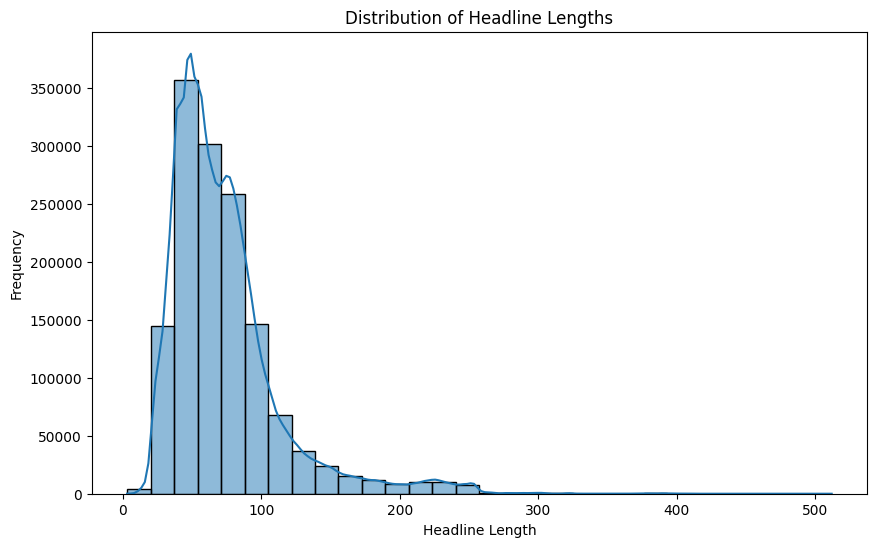

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


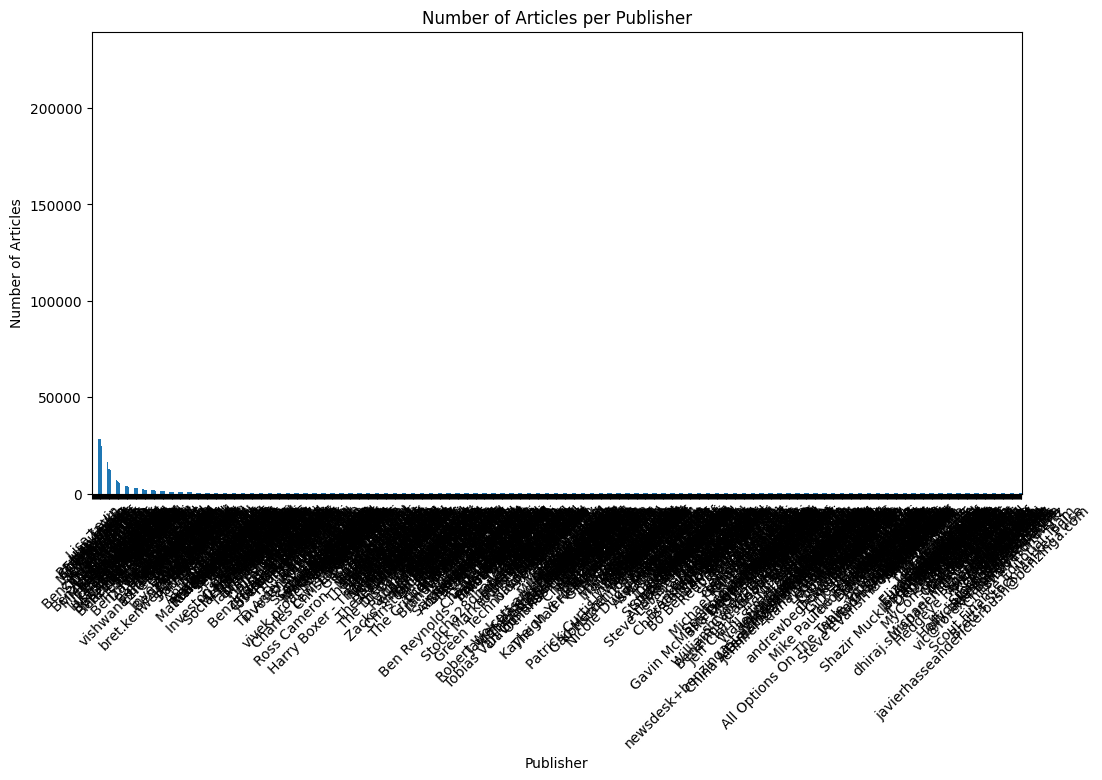

In [5]:
publisher_counts = df['publisher'].value_counts()
print(publisher_counts)
plt.figure(figsize=(12,6))
publisher_counts.plot(kind='bar')
plt.title('Number of Articles per Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()


In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

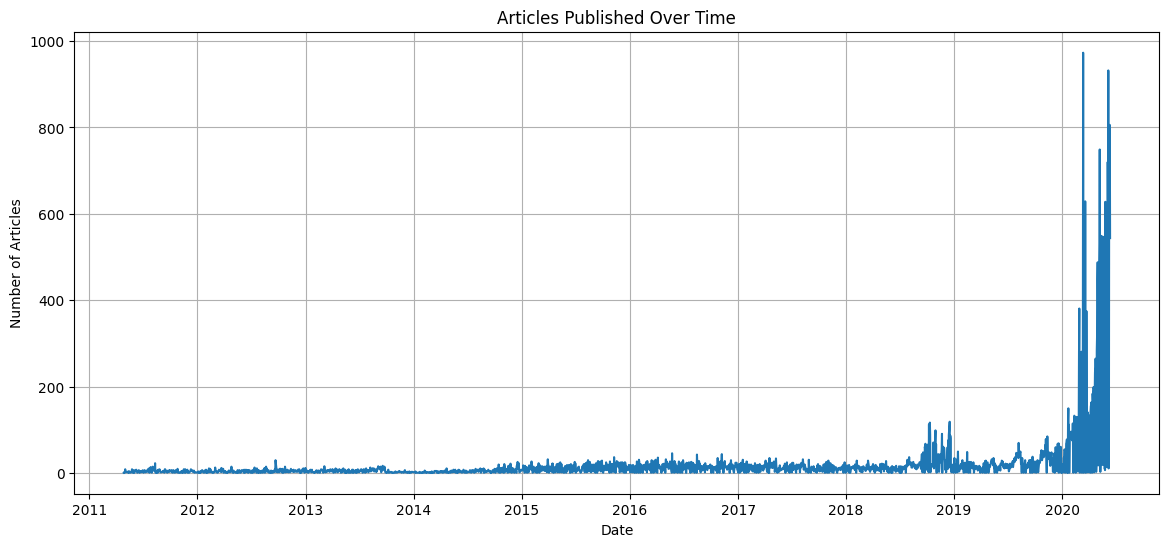

In [7]:
articles_per_day = df.groupby(df['date'].dt.date).size()

plt.figure(figsize=(14,6))
articles_per_day.plot()
plt.title('Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()


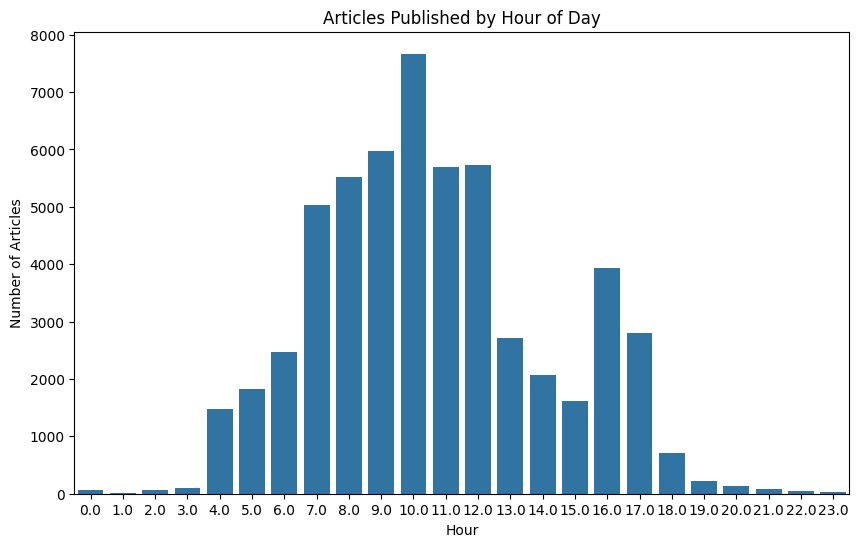

In [8]:
df['hour'] = df['date'].dt.hour

plt.figure(figsize=(10,6))
sns.countplot(x='hour', data=df)
plt.title('Articles Published by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Articles')
plt.show()


In [9]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_headline'] = df['headline'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bisrat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1,2))
X = vectorizer.fit_transform(df['cleaned_headline'])

keywords = vectorizer.get_feature_names_out()
print("Top keywords and bigrams:")
print(keywords)


Top keywords and bigrams:
['announces' 'bank' 'benzingas' 'benzingas top' 'buy' 'companies'
 'downgrades' 'earnings' 'energy' 'eps' 'eps vs' 'est' 'estimate' 'higher'
 'inc' 'initiates' 'lower' 'lowers' 'maintains' 'market' 'market update'
 'midday' 'moving' 'neutral' 'new' 'premarket' 'price' 'price target' 'pt'
 'raises' 'reports' 'reports eps' 'sales' 'says' 'scheduled' 'sees'
 'session' 'shares' 'stock' 'stocks' 'stocks moving' 'target' 'top'
 'trading' 'update' 'upgrades' 'us' 'vs' 'vs est' 'week']


In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
count_data = count_vectorizer.fit_transform(df['cleaned_headline'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(count_data)

def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx+1}:")
        print([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

display_topics(lda, count_vectorizer.get_feature_names_out(), 10)


Topic 1:
['earnings', 'pt', 'buy', 'raises', 'target', 'maintains', 'price', 'downgrades', 'initiates', 'neutral']
Topic 2:
['vs', 'est', 'eps', 'reports', 'sales', 'stocks', 'session', 'moving', 'sees', 'estimate']
Topic 3:
['benzingas', 'etfs', 'upgrades', 'downgrades', 'etf', 'stock', 'morning', 'premarket', 'watch', 'ahead']
Topic 4:
['says', 'announces', 'share', 'reports', 'new', 'industry', 'update', 'energy', 'stocks', 'deal']
Topic 5:
['shares', 'stocks', 'market', 'week', 'trading', 'higher', 'update', 'companies', 'lower', 'biggest']


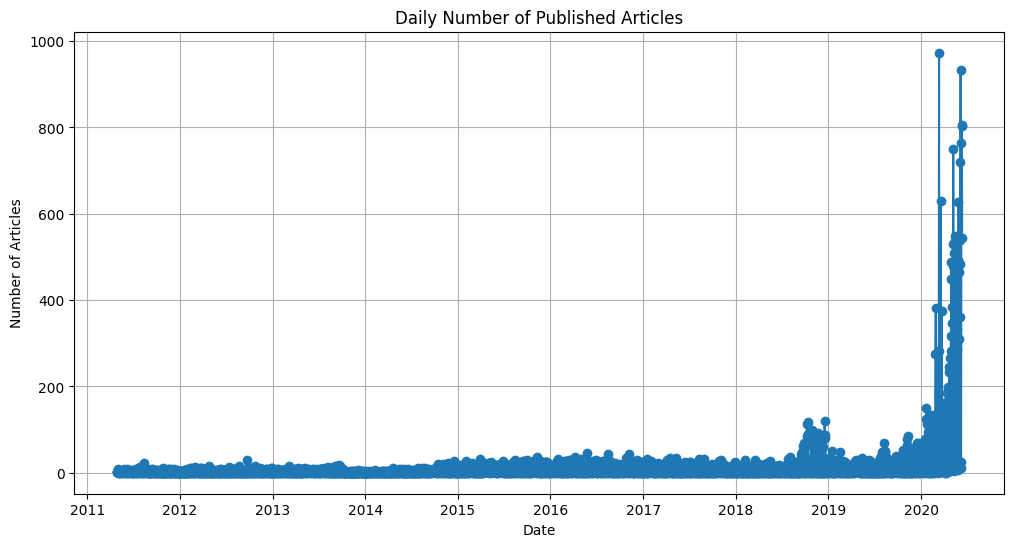

In [18]:
daily_counts = df['headline'].resample('D').count()

plt.figure(figsize=(12,6))
plt.plot(daily_counts, marker='o', linestyle='-')
plt.title('Daily Number of Published Articles')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.show()

In [13]:
threshold = daily_counts.mean() + 2 * daily_counts.std()
spike_days = daily_counts[daily_counts > threshold]
print("Spike days with unusually high article counts:")
print(spike_days)


Spike days with unusually high article counts:
date
2020-01-22 00:00:00-04:00    150
2020-02-27 00:00:00-04:00    275
2020-02-28 00:00:00-04:00    381
2020-03-05 00:00:00-04:00    138
2020-03-06 00:00:00-04:00    281
                            ... 
2020-06-05 00:00:00-04:00    932
2020-06-08 00:00:00-04:00    765
2020-06-09 00:00:00-04:00    804
2020-06-10 00:00:00-04:00    806
2020-06-11 00:00:00-04:00    544
Name: headline, Length: 61, dtype: int64


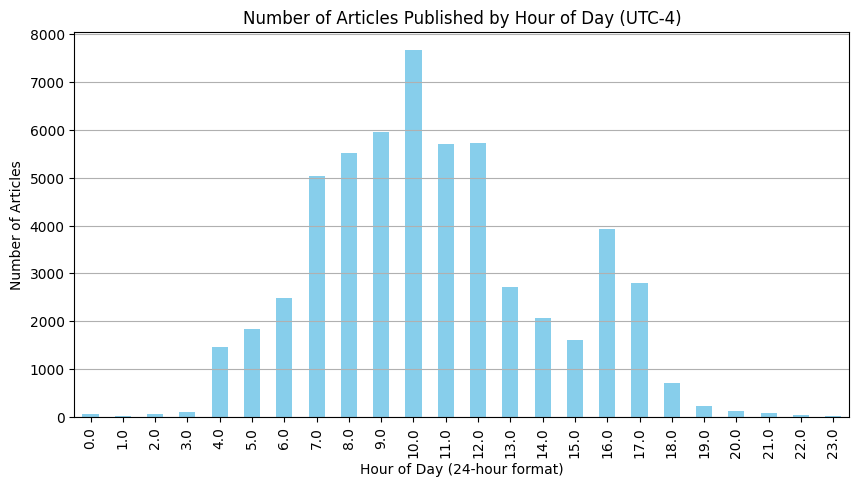

In [14]:
df['hour'] = df.index.hour

hourly_counts = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Published by Hour of Day (UTC-4)')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Number of Articles')
plt.grid(axis='y')
plt.show()


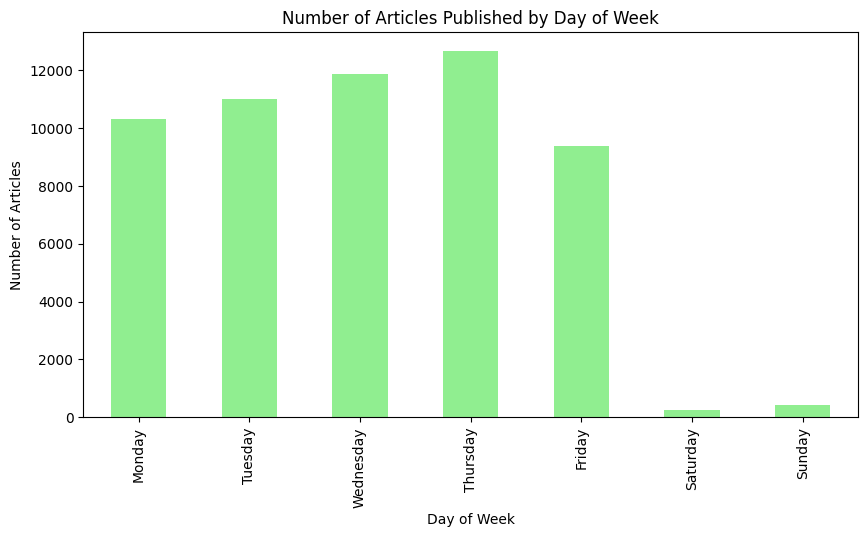

In [15]:
df['day_of_week'] = df.index.day_name()

weekday_counts = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10,5))
weekday_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Articles Published by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Articles')
plt.show()


In [16]:
publisher_counts = df['publisher'].value_counts()

print("Top publishers by article count:")
print(publisher_counts.head(10))


Top publishers by article count:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


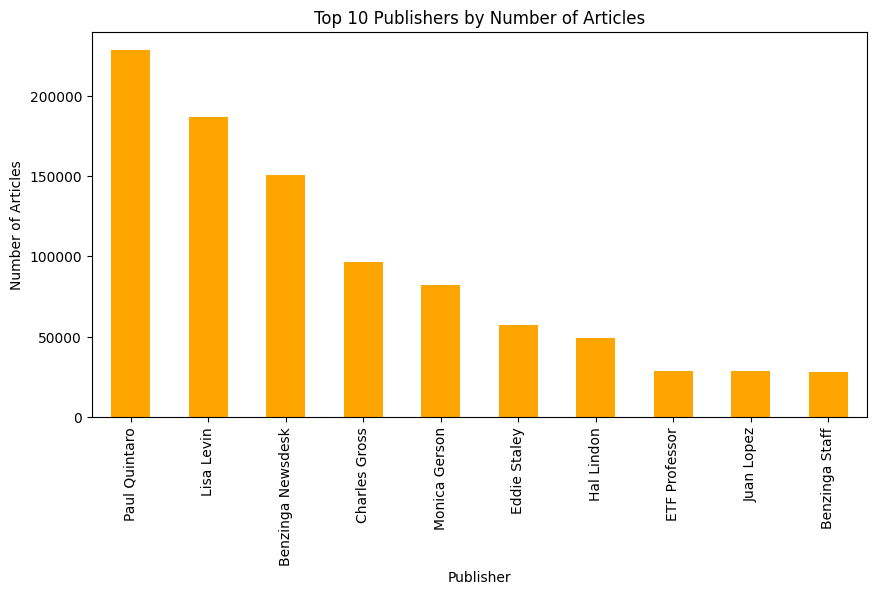

In [19]:
publisher_counts.head(10).plot(kind='bar', figsize=(10,5), color='orange')
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()


In [20]:
def extract_domain(publisher):
    if re.match(r"[^@]+@[^@]+\.[^@]+", publisher):
        return publisher.split('@')[1].lower()
    else:
        return None

df['publisher_domain'] = df['publisher'].apply(extract_domain)

domain_counts = df['publisher_domain'].dropna().value_counts()

print("Top publisher domains:")
print(domain_counts.head(10))


Top publisher domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


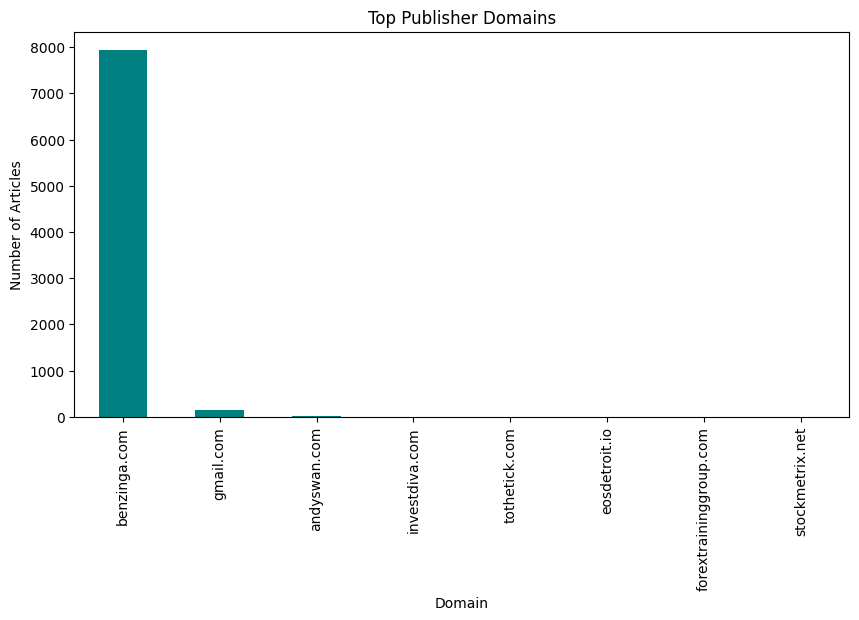

In [21]:
domain_counts.head(10).plot(kind='bar', figsize=(10,5), color='teal')
plt.title('Top Publisher Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.show()

In [22]:
keywords = ['FDA approval', 'price target', 'earnings', 'merger']

for kw in keywords:
    df[f'keyword_{kw}'] = df['headline'].str.contains(kw, case=False, na=False)

for kw in keywords:
    print(f"\nNumber of articles mentioning '{kw}' by publisher:")
    print(df[df[f'keyword_{kw}']].groupby('publisher').size().sort_values(ascending=False).head(5))



Number of articles mentioning 'FDA approval' by publisher:
publisher
Paul Quintaro        449
Benzinga Newsdesk    291
Charles Gross        159
Hal Lindon           126
Eddie Staley         103
dtype: int64

Number of articles mentioning 'price target' by publisher:
publisher
Vick Meyer           21615
Benzinga_Newsdesk     7082
Lisa Levin            4694
Paul Quintaro         3029
Benzinga Newsdesk     3023
dtype: int64

Number of articles mentioning 'earnings' by publisher:
publisher
Lisa Levin           20931
Monica Gerson        19510
Charles Gross         7628
Benzinga Newsdesk     5068
Nelson Hem            4087
dtype: int64

Number of articles mentioning 'merger' by publisher:
publisher
Paul Quintaro        1012
Charles Gross         791
Benzinga Newsdesk     729
Hal Lindon            378
Eddie Staley          249
dtype: int64
